In [1]:
import comet_ml

import tensorflow as tf
import keras
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


import os
import time
import IPython

import h5py
import mitdeeplearning as mdl

import functools
from tqdm import tqdm

2024-05-29 21:51:52.995249: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-29 21:51:52.995303: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-29 21:51:52.996323: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-29 21:51:53.002704: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Before Running This Notebook:
### Create a .txt file called "comet_key"
### Paste your Comet API Key into comet_key.txt

# Additional Notes
### Just to be safe, I have tagged most of the custom functions with @keras.saving.register_keras_serializable()

In [2]:
# Package Parameters
CWD = os.getcwd()
print(CWD)

key_file = open(f'{CWD}/comet_key.txt')
COMET_API_KEY = key_file.read()
matplotlib.rcParams['font.family'] = "Times New Roman"


current_time = time.gmtime(time.time())
print(current_time)

### Create a Comet experiment to track our training run ###
def create_experiment(project_name, params):
    # end any prior experiments
    if 'experiment' in locals():
        experiment.end()

    # initiate the comet experiment for tracking
    experiment = comet_ml.Experiment(
    api_key=COMET_API_KEY,
    project_name=project_name)
    # log our hyperparameters, defined above, to the experiment
    for param, value in params.items():
        experiment.log_parameter(param, value)
    experiment.flush()

    return experiment

### Ensure training on GPU ###
assert len(tf.config.list_physical_devices('GPU')) > 0
assert COMET_API_KEY != "", "Please insert your Comet API Key"
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if physical_devices:
    for device in physical_devices:
        tf.config.experimental.set_memory_growth(device, True)

/mnt/e/AP Research/Polished-Capstone
time.struct_time(tm_year=2024, tm_mon=5, tm_mday=30, tm_hour=2, tm_min=51, tm_sec=54, tm_wday=3, tm_yday=151, tm_isdst=0)


2024-05-29 21:51:54.777273: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-29 21:51:54.802782: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-29 21:51:54.802822: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.


# Data Loading

In [3]:
### Function: load dataset ###
@keras.saving.register_keras_serializable(package='capstone',name='load_dataset')
def load_dataset(path_to_training_data):
    with h5py.File(path_to_training_data) as f:
        # Print the keys (names) of all groups and datasets in the file
        print("Keys:", list(f.keys()))

        # Iterate through each key and print more detailed information
        for key in f.keys():
            if isinstance(f[key], h5py.Dataset):
                print(f"Dataset: {key}")
                print("  Shape:", f[key].shape)
                print("  Data type:", f[key].dtype)
                
    ### Instantiate Loader Function ###
    return mdl.lab2.TrainingDatasetLoader(path_to_training_data)

In [4]:
### Function: visualize dataset ###
@keras.saving.register_keras_serializable(package='capstone',name='visualize_dataset')
def visualize_dataset(path_to_training_data, loader):
    ### Visualize our data ###
    number_of_training_examples = loader.get_train_size()
    print(number_of_training_examples)
    (images, labels) = loader.get_batch(100)
    malignant_images = images[np.where(labels==1)[0]]
    benign_images = images[np.where(labels==0)[0]]

    idx_malignant = 23
    idx_benign = 9

    plt.figure(figsize=(5,5))
    plt.subplot(1, 2, 1)
    plt.imshow(malignant_images[idx_malignant])
    plt.title("Malignant"); plt.grid(False)

    plt.subplot(1, 2, 2)
    plt.imshow(benign_images[idx_benign])
    plt.title("Benign"); plt.grid(False)

In [5]:
### Instantiate Loaders: train/val 90/10 ###
loader_ISIC = load_dataset(f'{CWD}/datasets/split-90train-10val/train_ISIC.h5')
loader_ISIC_DiDI = load_dataset(f'{CWD}/datasets/split-90train-10val/train_ISIC_DiDI.h5')
loader_ISIC_ArGI = load_dataset(f'{CWD}/datasets/split-90train-10val/train_ISIC_ArGI.h5')

loader_val_ISIC = load_dataset(f'{CWD}/datasets/split-90train-10val/val_ISIC.h5')
loader_val_ISIC_DiDI = load_dataset(f'{CWD}/datasets/split-90train-10val/val_ISIC_DiDI.h5')
loader_val_ISIC_ArGI =  load_dataset(f'{CWD}/datasets/split-90train-10val/val_ISIC_ArGI.h5')

Keys: ['images', 'labels']
Dataset: images
  Shape: (1778, 64, 64, 3)
  Data type: uint8
Dataset: labels
  Shape: (1778, 1)
  Data type: float64
Opening /mnt/e/AP Research/Polished-Capstone/datasets/split-90train-10val/train_ISIC.h5
Loading data into memory...
Keys: ['images', 'labels']
Dataset: images
  Shape: (2368, 64, 64, 3)
  Data type: uint8
Dataset: labels
  Shape: (2368, 1)
  Data type: float64
Opening /mnt/e/AP Research/Polished-Capstone/datasets/split-90train-10val/train_ISIC_DiDI.h5
Loading data into memory...
Keys: ['images', 'labels']
Dataset: images
  Shape: (2368, 64, 64, 3)
  Data type: uint8
Dataset: labels
  Shape: (2368, 1)
  Data type: float64
Opening /mnt/e/AP Research/Polished-Capstone/datasets/split-90train-10val/train_ISIC_ArGI.h5
Loading data into memory...
Keys: ['images', 'labels']
Dataset: images
  Shape: (198, 64, 64, 3)
  Data type: uint8
Dataset: labels
  Shape: (198, 1)
  Data type: float64
Opening /mnt/e/AP Research/Polished-Capstone/datasets/split-90tr

1778
2368
2368


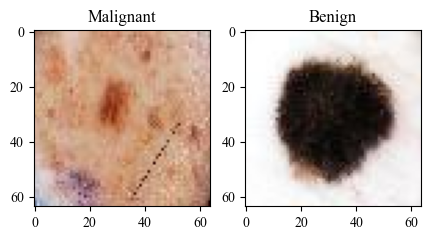

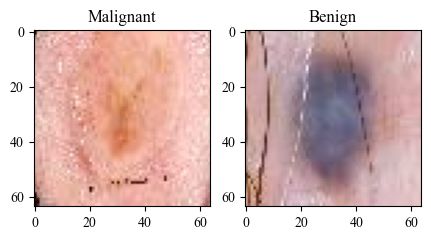

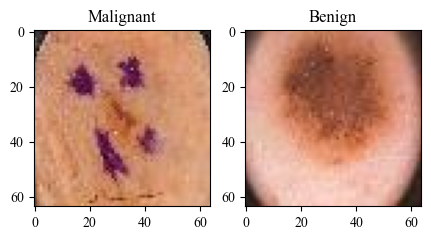

In [6]:
### Visualize Training Datasets ###
visualize_dataset(f'{CWD}/datasets/train_ISIC.h5', loader_ISIC)
visualize_dataset(f'{CWD}/datasets/train_ISIC_DiDI.h5', loader_ISIC_DiDI)
visualize_dataset(f'{CWD}/datasets/train_ISIC_ArGI.h5', loader_ISIC_ArGI)

# Create Model Architectures

In [7]:
### Standard CNN ###

# Helper Functions

@keras.saving.register_keras_serializable(package='capstone', name='resize_images')
def resize_images(x):
    return tf.image.resize(x, (64, 64))

# CNN Function
@keras.saving.register_keras_serializable(package='capstone', name='make_standard_ResNet50_V2')
def make_standard_ResNet50_V2(n_outputs = 1):
    
    Resize = tf.keras.layers.Lambda(resize_images)
    Flatten = tf.keras.layers.Flatten
    Dense = functools.partial(tf.keras.layers.Dense, activation='relu')
    ResNet50V2 = tf.keras.applications.ResNet50V2(
        include_top=False,
        weights="imagenet", # Utilizing Transfer Learning, also maintains consistency
        input_tensor=None,
        input_shape=(64,64,3),
        pooling=None,
        classes=1000,
        classifier_activation="softmax",
    )
    ResNet50V2 = tf.keras.Model(inputs = ResNet50V2.layers[1].input, 
                                outputs = ResNet50V2.layers[-1].output)

    model = tf.keras.Sequential()
    
    model.add(Resize)
    model.add(ResNet50V2)
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Dense(n_outputs, activation=None))

    return model

In [8]:
### DB-VAE ###

### Define Decoder Network ###
@keras.saving.register_keras_serializable(package='capstone', name='make_decoder_network')
def make_decoder_network(latent_dim = 100, n_filters = 12 ):
    """
    Layer Types, Functional Definition
    """
    Conv2DTranspose = functools.partial(tf.keras.layers.Conv2DTranspose, padding='same', activation='relu')
    Dense = functools.partial(tf.keras.layers.Dense, activation='relu')
    Reshape = tf.keras.layers.Reshape 
    BatchNormalization = tf.keras.layers.BatchNormalization
    LeakyReLU = tf.keras.layers.LeakyReLU
    # Decoder
    decoder = tf.keras.Sequential([
        Dense(units=4*4*6*n_filters),
        Reshape(target_shape=(4,4,6*n_filters)),

        Conv2DTranspose(256, (4, 4), strides=(2, 2), padding='same'),
        BatchNormalization(),
        LeakyReLU(alpha=0.2),

        Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'),
        BatchNormalization(),
        LeakyReLU(alpha=0.2),

        Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same'),
        BatchNormalization(),
        LeakyReLU(alpha=0.2),

        Conv2DTranspose(3, (4, 4), strides=(2, 2), padding='same', activation='sigmoid')
    ])
    
    return decoder

### DB_VAE Helper Functions ###


### VAE Reparameterization ###
@keras.saving.register_keras_serializable(package='capstone', name='sampling_VAE_reparameterization')
def sampling(z_mean, z_logsigma):
    batch, latent_dim = z_mean.shape
    epsilon = tf.random.normal(shape=(batch, latent_dim))
    z = z_mean + tf.math.exp(0.5 * z_logsigma) * epsilon
    return z

### Defining the VAE loss function ###
@keras.saving.register_keras_serializable(package='capstone', name='vae_loss_function')
def vae_loss_function(x, x_recon, mu, logsigma, kl_weight=0.0005):
  latent_loss = 0.5 * tf.reduce_sum(tf.exp(logsigma) + tf.square(mu) - 1.0 - logsigma, axis=1)
  reconstruction_loss = tf.reduce_mean(tf.abs(x-x_recon), axis=(1,2,3))
  vae_loss = kl_weight * latent_loss + reconstruction_loss
  return vae_loss

### Loss function for DB-VAE ###
@keras.saving.register_keras_serializable(package='capstone',name='debiasing_loss_function')
def debiasing_loss_function(x, x_pred, y, y_logit, mu, logsigma):
  vae_loss = vae_loss_function(x, x_pred, mu, logsigma)
  classification_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=y_logit)
  malignance_indicator = tf.cast(tf.equal(y, 1), tf.float32)
  total_loss = tf.reduce_mean(
      classification_loss +
      malignance_indicator * vae_loss
  )
  return total_loss, classification_loss

### Defining and creating the DB-VAE ###
@keras.saving.register_keras_serializable(package='capstone')
class DB_VAE(tf.keras.Model):
  def __init__(self, latent_dim):
    super(DB_VAE, self).__init__()
    self.latent_dim = latent_dim

    # Define the number of outputs for the encoder. Recall that we have
    # `latent_dim` latent variables, as well as a supervised output for the
    # classification.
    num_encoder_dims = 2*self.latent_dim + 1

    self.encoder = make_standard_ResNet50_V2(num_encoder_dims)
    self.decoder = make_decoder_network()

  def encode(self, x):
    encoder_output = self.encoder(x)
    y_logit = tf.expand_dims(encoder_output[:, 0], -1)
    z_mean = encoder_output[:, 1:self.latent_dim+1]
    z_logsigma = encoder_output[:, self.latent_dim+1:]

    return y_logit, z_mean, z_logsigma

  def reparameterize(self, z_mean, z_logsigma):
    z = sampling(z_mean, z_logsigma)
    return z

  def decode(self, z):
    reconstruction = self.decoder(z)
    return reconstruction

  def call(self, x):
    y_logit, z_mean, z_logsigma = self.encode(x)
    z = self.reparameterize(z_mean, z_logsigma)
    recon = self.decode(z)
    return y_logit, z_mean, z_logsigma, recon

  def predict(self, x):
    y_logit, z_mean, z_logsigma = self.encode(x)
    return y_logit
  
### DB_VAE Training Helper Functions ###

# Function to return the means for an input image batch
@keras.saving.register_keras_serializable(package='capstone',name='get_latent_mu')
def get_latent_mu(images, dbvae, batch_size=1024, latent_dim=100):
    N = images.shape[0]
    mu = np.zeros((N, latent_dim))
    for start_ind in range(0, N, batch_size):
        end_ind = min(start_ind+batch_size, N+1)
        batch = (images[start_ind:end_ind]).astype(np.float32)/255.
        _, batch_mu, _ = dbvae.encode(batch)
        mu[start_ind:end_ind] = batch_mu
    return mu

@keras.saving.register_keras_serializable(package='capstone',name='get_training_sample_probabilities')
def get_training_sample_probabilities(images, dbvae, bins=10, smoothing_fac=0.001, latent_dim=100):
    print("Recomputing the sampling probabilities")
    mu = get_latent_mu(images, dbvae)
    training_sample_p = np.zeros(mu.shape[0])
    for i in range(latent_dim):
        latent_distribution = mu[:,i]
        hist_density, bin_edges =  np.histogram(latent_distribution, density=True, bins=bins)
        bin_edges[0] = -float('inf')
        bin_edges[-1] = float('inf')
        bin_idx = np.digitize(latent_distribution, bin_edges)
        hist_smoothed_density = hist_density + smoothing_fac
        hist_smoothed_density = hist_smoothed_density / np.sum(hist_smoothed_density)
        p = 1.0/(hist_smoothed_density[bin_idx-1])
        p = p / np.sum(p)
        training_sample_p = np.maximum(p, training_sample_p)
    training_sample_p /= np.sum(training_sample_p)

    return training_sample_p

In [9]:
### Set Training Hyperparamters ###

### Hyperparameters for CNN Training ###
params_CNN = dict( 
  batch_size = 32,
  num_epochs = 20,
  learning_rate = 5e-4,
  patience = 5, # for early stopping
)

### Hyperparameters for DB-VAE Training ###
params_DB_VAE = dict(
    batch_size = 32,
    num_epochs = 50, 
    learning_rate = 5e-4,
    latent_dim = 100,
)

# Training

In [10]:
### Start Base CNN Experiment ###
@keras.saving.register_keras_serializable(package='capstone',name='experiment_base_CNN')
def experiment_base_CNN(model_num, data_loader, params, validation_loader):

    ### Instantiate new model ###
    model = make_standard_ResNet50_V2()

    ### Train the standard CNN ###
    experiment = create_experiment(f"{current_time.tm_year}-{current_time.tm_mon}-{current_time.tm_mday}_Model_{model_num}", params)

    optimizer = tf.keras.optimizers.Adam(params["learning_rate"]) # define our optimizer
    loss_history = mdl.util.LossHistory(smoothing_factor=0.99) # to record loss evolution
    plotter = mdl.util.PeriodicPlotter(sec=2, scale='semilogy')
    if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists

    train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
    train_loss_metric = tf.keras.metrics.SparseCategoricalCrossentropy()
    val_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
    val_loss_metric = tf.keras.metrics.SparseCategoricalCrossentropy()

    @tf.function
    def standard_train_step(x, y):
        with tf.GradientTape() as tape:
            # feed the images into the model
            logits = model(x)
            # Compute the loss
            loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits)

        # Backpropagation
        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        train_acc_metric.update_state(y, logits)
        train_loss_metric.update_state(y, logits)

        return loss

    @tf.function
    def test_step(x,y):
        logits = model(x, training=False)
        val_acc_metric.update_state(y, logits)
        val_loss_metric.update_state(y, logits)

    # The training loop!
    wait = 0
    best = float('inf')

    step = 0
    completed_epochs = 0
    for epoch in range(params["num_epochs"]):

        print("\nStart of epoch %d" % (epoch,))
        start_time = time.time()

        # Training
        for idx in tqdm(range(data_loader.get_train_size()//params["batch_size"])):
            # Grab a batch of training data and propagate through the network
            x, y = data_loader.get_batch(params["batch_size"])

            loss = standard_train_step(x, y)

            # Record the loss and plot the evolution of the loss as a function of training
            loss_history.append(loss.numpy().mean())
            plotter.plot(loss_history.get())

            experiment.log_metric("loss", loss.numpy().mean(), step=step)
            step += 1

        train_acc = train_acc_metric.result()
        train_loss = train_loss_metric.result()
        train_acc_metric.reset_states()
        train_loss_metric.reset_states()
        print("Training acc over epoch: %.4f" % (train_acc.numpy()))

        # Validation
        for idx in tqdm(range(validation_loader.get_train_size()//params['batch_size'])):
            x, y = validation_loader.get_batch(params['batch_size'])
            test_step(x, y)

        val_acc = val_acc_metric.result()
        val_loss = val_loss_metric.result()
        val_acc_metric.reset_states()
        val_loss_metric.reset_states()
        print("Validation acc: %.4f" % (float(val_acc),))
        print("Time taken: %.2fs" % (time.time() - start_time))

        completed_epochs += 1
        wait += 1
        if val_loss < best:
            best = val_loss
            wait = 0
        if wait >= params['patience']:
            print("EARLY STOP")
            break


    ### Obtain Loss Values Over Epoch ###
    steps = len(loss_history.get())
    print(steps)

    epochs = np.uint8(completed_epochs)
    batches_per_epoch = np.uint8(steps/epochs)

    loss_hist = np.zeros((steps,1))
    for i in range(steps):
        loss_hist[i] = loss_history.get()[i]
    print([epochs, batches_per_epoch])
    print(f'Loss_hist: {loss_hist.shape}')

    loss_hist = loss_hist.reshape(epochs, batches_per_epoch)

    row_means = np.zeros((epochs))
    for i in range(epochs):
        row_means[i] = loss_hist.sum(axis=1)[i]

    row_means = row_means/batches_per_epoch
    for mean in row_means:
        print(mean)

    experiment.end()
    return model, row_means, completed_epochs

In [11]:
### Start DB-VAE Experiment ###
@keras.saving.register_keras_serializable(package='capstone',name='experiment_DB_VAE')
def experiment_DB_VAE(model_num, data_loader, params):
    
    ### Instantiate new model ###
    model = DB_VAE(params["latent_dim"])
    
    experiment = create_experiment(f"{current_time.tm_year}-{current_time.tm_mon}-{current_time.tm_mday}_Model_{model_num}", params)

    optimizer = tf.keras.optimizers.Adam(params["learning_rate"])

    @tf.function
    def debiasing_train_step(x, y):
        with tf.GradientTape() as tape:
            y_logit, z_mean, z_logsigma, x_recon = model(x)
            loss, class_loss = debiasing_loss_function(x, x_recon, y, y_logit, z_mean, z_logsigma)
        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        return loss

    all_imgs = data_loader.get_all_train_faces()

    if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists

    loss_history_2 = mdl.util.LossHistory(smoothing_factor=0.99) # to record loss evolution
    # The training loop -- outer loop iterates over the number of epochs
    step = 0
    for i in range(params["num_epochs"]):

        IPython.display.clear_output(wait=True)
        print("Starting epoch {}/{}".format(i+1, params["num_epochs"]))
        p_lesions = get_training_sample_probabilities(all_imgs, model)

        for j in tqdm(range(data_loader.get_train_size() // params["batch_size"])):
            # load a batch of data
            (x, y) = data_loader.get_batch(params["batch_size"], p_pos=p_lesions)

            # loss optimization
            loss = debiasing_train_step(x, y)
            experiment.log_metric("loss", loss.numpy().mean(), step=step, epoch=i+1)
            loss_history_2.append(loss.numpy().mean())
            # plot the progress every 200 steps
            if j % 500 == 0:
                mdl.util.plot_sample(x, y, model)

            step += 1

    ### Obtain Loss Values Over Epoch ###
    steps = len(loss_history_2.get())
    print(steps)

    epochs = np.uint8(params['num_epochs'])
    batches_per_epoch = np.uint8(steps/epochs)

    loss_hist = np.zeros((steps,1))
    for i in range(steps):
        loss_hist[i] = loss_history_2.get()[i]
    loss_hist = loss_hist.reshape(epochs, batches_per_epoch)

    row_means = np.zeros((epochs))
    for i in range(epochs):
        row_means[i] = loss_hist.sum(axis=1)[i]

    row_means = row_means/batches_per_epoch
    for mean in row_means:
        print(mean)

    experiment.end()

    return model, row_means

In [12]:
@keras.saving.register_keras_serializable(package='capstone',name='graph_loss')
def graph_loss(model_num, row_means, epochs):
    epochs_range = np.arange(1,epochs+1)
    plt.figure(figsize=(8,7))
    size_axis_titles = 16
    size_title = 18
    size_legend = 14
    plt.xlabel("Epoch", fontsize=size_axis_titles)
    plt.ylabel("Loss", fontsize=size_axis_titles)
    plt.axis([1, 50, 0, 2.5])
    plt.plot(epochs_range, row_means, label='Training')
    plt.legend(loc='upper right', fontsize=size_legend)
    plt.title(f'Training Loss for Model {model_num}', fontsize=size_title)
    plt.show()

In [13]:
### Set Testing Hyperparameters ###
params_test = dict(
    runs = 30,
    batch_size = 256,
)

In [14]:
@keras.saving.register_keras_serializable(package='capstone',name='evaluate')
def evaluate(model, runs, batch_size):
    ### Evaluation of model on test dataset (n = 526) ###

    ### Confusion Matrices ###
    """
    | TP  FP |
    | FN  TN |
    where TP is true positive
    FP is false positive
    FN is false negative
    TN is true negative
    Precision equals TP / (TP + FP)
    Recall equals TP / (FN + TP)
    harmonic mean of precision and recall gives F1 score
    F1 = 2 * (precision * recall) / (precision + recall)

    Sensitivity: TP / (FN + TP)

    Specificity: TN / (FP + TN)
    """

    from sklearn.metrics import confusion_matrix

    acc, spec, sens, pre, rec, f1s = np.empty(shape=[runs])
    for i in range(runs):
        # print(batch_x.shape) # (256, 64, 64, 3), these are the test images
        # print(batch_y.shape) # (256, 1), these are the test labels
        (batch_x, batch_y) = loader_test.get_batch(batch_size)

        ### Predict on the test batch ###
        """
        returns an EagerTensor when it's a DB-VAE but a numpy array when it's a CNN. 
        I don't know why.
        """
        
        y_pred_standard = tf.round(tf.nn.sigmoid(model.predict(batch_x)))
        acc_standard = tf.reduce_mean(tf.cast(tf.equal(batch_y, y_pred_standard), tf.float32))
   
        cm = confusion_matrix(batch_y, y_pred_standard)

        assert batch_size == np.sum(cm)
        
        tp = cm[0,0]
        fp = cm[0,1]
        fn = cm[1,0]
        tn = cm[1,1]
        
        accuracy, specificity, sensitivity, precision, recall, f1score = 0, 0, 0, 0, 0, 0

        ### Compute Accuracy: TP + FP divided by batch_size ###
        assert np.sum(cm) != 0
        accuracy = float(tp + tn) / float(batch_size)
        assert accuracy == acc_standard # sanity check

        ### Compute Sensitivity: TP divided by FN + TP ###
        ### Sensitivity is the same as Recall ###
        assert fn + tp != 0
        sensitivity = float(tp) / float(tp + fn)
        recall = sensitivity

        ### Compute Specificity: TN divided by FP + TN ###
        assert tn + fp != 0
        specificity = float(tn) / float(fp + tn)

        ### Compute Precision: TP divided by TP + FP ###
        assert tp + fp != 0
        precision = float(tp) / float(tp + fp)

        ### Compute F1-Score: two times the product of precision and recall, divided by the sum of precision and recall ###
        assert precision + recall != 0
        f1score = 2 * precision * recall / float(precision + recall)

        # print(cm)
        # print(f'accuracy: {accuracy}')
        # print(f'specificity: {specificity}')
        # print(f'sensitivity: {sensitivity}')
        # print(f'precision: {precision}')
        # print(f'F1-score: {f1score}')

        acc[i] = accuracy
        spec[i] = specificity
        sens[i] = sensitivity
        pre[i] = precision
        rec[i] = recall
        f1s[i] = f1score    
    
    return [acc.mean(), spec.mean(), sens.mean(), pre.mean(), rec.mean(), f1s.mean()]

Starting epoch 50/50
Recomputing the sampling probabilities


  0%|          | 0/55 [00:00<?, ?it/s]

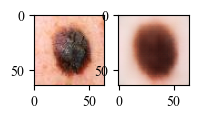

100%|██████████| 55/55 [00:05<00:00, 10.91it/s]
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/88mangos/2024-5-30-model-4/0d1a046c145f46468adc8255260fe770
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [2750] : (0.05061771720647812, 6.062105178833008)
COMET INFO:   Parameters:
COMET INFO:     Adam_amsgrad                 : False
COMET INFO:     Adam_beta_1                  : 0.9
COMET INFO:     Adam_beta_2                  : 0.999
COMET INFO:     Adam_clipnorm                : None
COMET INFO:     Adam_clipvalue               : None
COMET INFO:     Adam_ema_momentum            : 0.99
COMET INFO:     Adam_ema_overwrite_frequency : None
COMET INFO:     Adam_eps

2750
1.2154731478416019
1.013756484471374
0.8714986601479487
0.7717002645035496
0.7091998296662959
0.6721244674502341
0.6440147696373698
0.6342376725530179
0.6369273777088665
0.609770962072448
0.583000086404596
0.5752531715154275
0.5561929131022519
0.5243866670298354
0.5131863729133368
0.5142886672313313
0.4990420981876678
0.46347147221135965
0.4300573685887688
0.4143211139552711
0.39682745461772434
0.36664316770143135
0.34139310018394914
0.334152552741075
0.3126641001866549
0.2923209898109943
0.2764200860646635
0.2660866937628672
0.26896451198234267
0.24646487183984783
0.22223496088954103
0.2225300531957845
0.21921599767008065
0.21476192370090938
0.21929946766342315
0.20042154784468877
0.17630065445919674
0.16159010672806606
0.15381854133001963
0.14221414798102106
0.13756063034575072
0.13848107158904535
0.13327825437284105
0.12819110233484643
0.12573562180703168
0.11768163723095625
0.11439824565351922
0.11392162198862463
0.11170023074323804
0.11793041233376132


COMET INFO: Please wait for metadata to finish uploading (timeout is 3600 seconds)
COMET INFO: Uploading 284 metrics, params and output messages


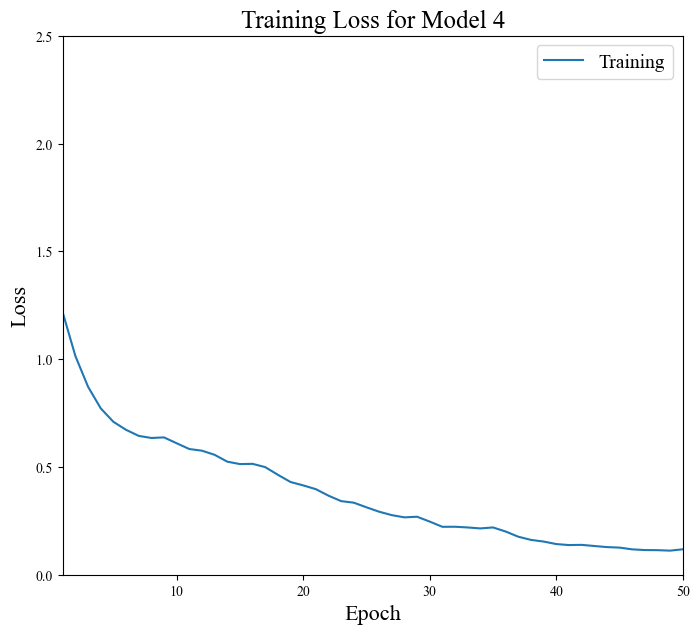

In [16]:
model_4, row_means_4 = experiment_DB_VAE(4, loader_ISIC, params_DB_VAE)
graph_loss(4, row_means_4, params_DB_VAE["num_epochs"])
model_4.save(f"{CWD}/models/{current_time.tm_year}-{current_time.tm_mon}-{current_time.tm_mday}_model_{4}.keras")
tf.keras.backend.clear_session()

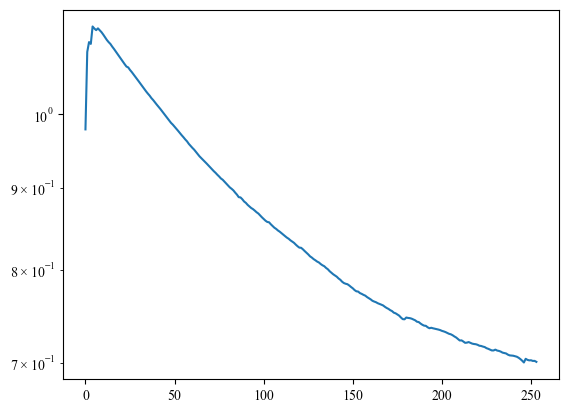

100%|██████████| 55/55 [00:04<00:00, 11.82it/s]


Training acc over epoch: 0.5000


100%|██████████| 6/6 [00:00<00:00, 56.24it/s]
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/88mangos/2024-5-30-model-1/d483c079853a4eb390a778ea150fd78d
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [275] : (0.5169812440872192, 12.493389129638672)
COMET INFO:   Parameters:
COMET INFO:     Adam_amsgrad                 : False
COMET INFO:     Adam_beta_1                  : 0.9
COMET INFO:     Adam_beta_2                  : 0.999
COMET INFO:     Adam_clipnorm                : None
COMET INFO:     Adam_clipvalue               : None
COMET INFO:     Adam_ema_momentum            : 0.99
COMET INFO:     Adam_ema_overwrite_frequency : None
COMET INFO:     Adam_epsilo

Validation acc: 0.5000
Time taken: 4.78s
EARLY STOP
275
[5, 55]
Loss_hist: (275, 1)
1.0541978185317833
0.9008614537311503
0.7998015483512924
0.7381506610960833
0.703834777903991


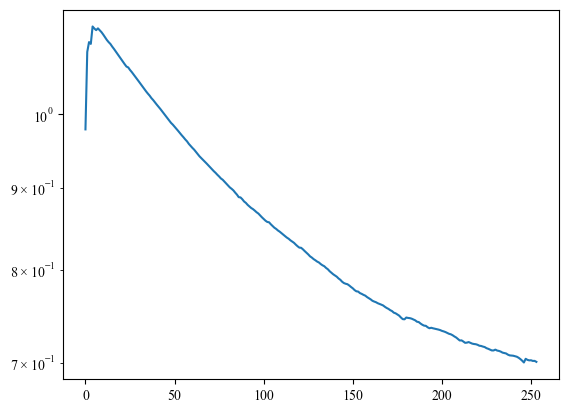

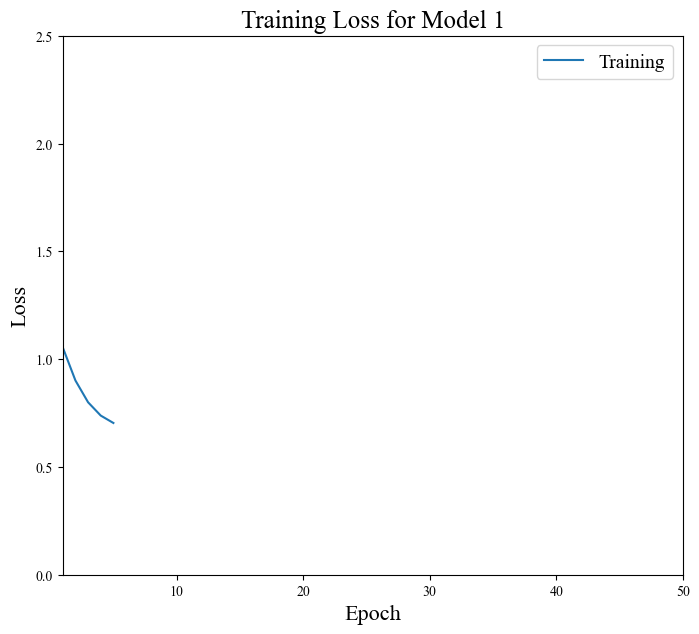

In [17]:
model_1, row_means_1, completed_epochs = experiment_base_CNN(1, loader_ISIC, params_CNN, loader_val_ISIC)
graph_loss(1, row_means_1, completed_epochs)
model_1.save(f"{CWD}/models/{current_time.tm_year}-{current_time.tm_mon}-{current_time.tm_mday}_model_{1}.keras")
tf.keras.backend.clear_session()

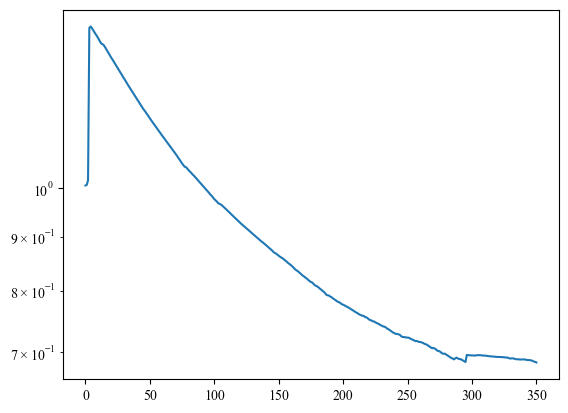

100%|██████████| 74/74 [00:06<00:00, 11.84it/s]


Training acc over epoch: 0.5000


100%|██████████| 8/8 [00:00<00:00, 59.77it/s]
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/88mangos/2024-5-30-model-2/b7bec838c2c647a2b7fdb8c70243fee0
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [370] : (0.48734381794929504, 41.08000564575195)
COMET INFO:   Parameters:
COMET INFO:     Adam_amsgrad                 : False
COMET INFO:     Adam_beta_1                  : 0.9
COMET INFO:     Adam_beta_2                  : 0.999
COMET INFO:     Adam_clipnorm                : None
COMET INFO:     Adam_clipvalue               : None
COMET INFO:     Adam_ema_momentum            : 0.99
COMET INFO:     Adam_ema_overwrite_frequency : None
COMET INFO:     Adam_epsilo

Validation acc: 0.5000
Time taken: 6.40s
EARLY STOP
370
[5, 74]
Loss_hist: (370, 1)
1.2245096735584104
0.9558034310558933
0.8028482145548786
0.7154397565141384
0.6890073710481897


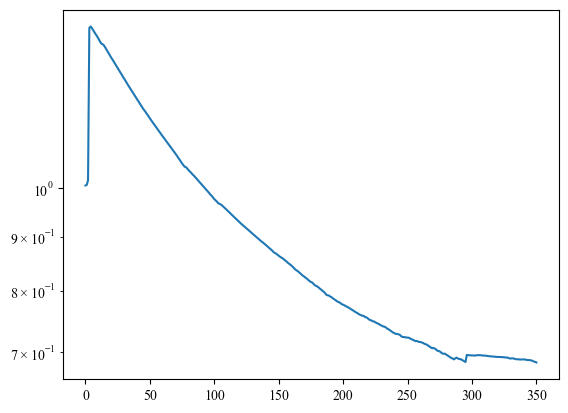

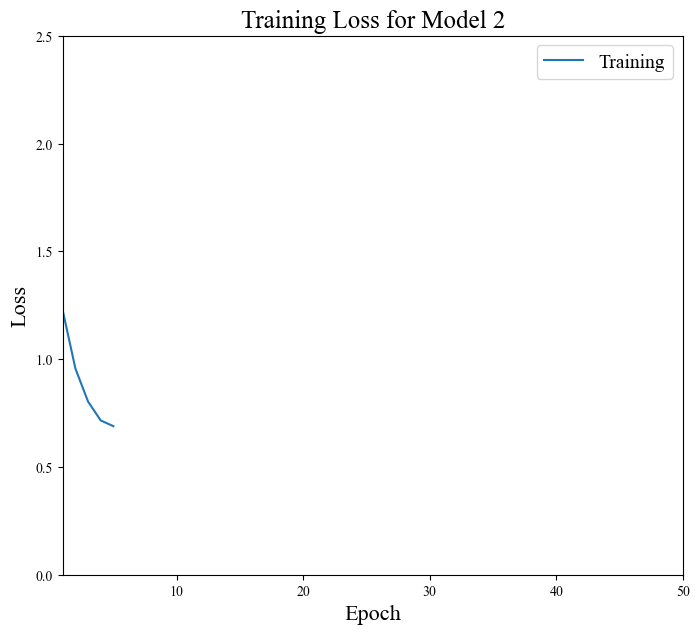

In [18]:
model_2, row_means_2, completed_epochs = experiment_base_CNN(2, loader_ISIC_DiDI, params_CNN, loader_val_ISIC_DiDI)
graph_loss(2, row_means_2, completed_epochs)
model_2.save(f"{CWD}/models/{current_time.tm_year}-{current_time.tm_mon}-{current_time.tm_mday}_model_{2}.keras")
tf.keras.backend.clear_session()

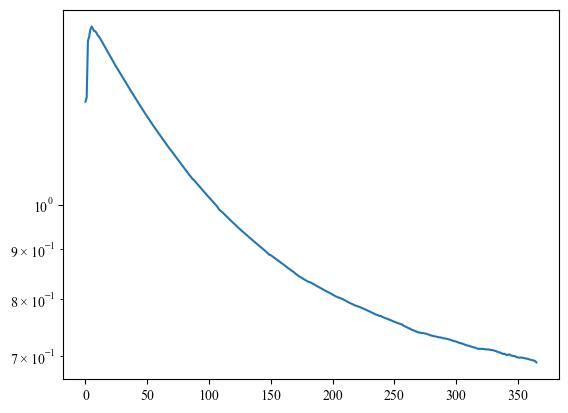

100%|██████████| 74/74 [00:06<00:00, 11.96it/s]


Training acc over epoch: 0.5000


100%|██████████| 8/8 [00:00<00:00, 51.73it/s]
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/88mangos/2024-5-30-model-3/fac1ebd7996a4b459486690140cc390d
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [370] : (0.48162806034088135, 19.558334350585938)
COMET INFO:   Parameters:
COMET INFO:     Adam_amsgrad                 : False
COMET INFO:     Adam_beta_1                  : 0.9
COMET INFO:     Adam_beta_2                  : 0.999
COMET INFO:     Adam_clipnorm                : None
COMET INFO:     Adam_clipvalue               : None
COMET INFO:     Adam_ema_momentum            : 0.99
COMET INFO:     Adam_ema_overwrite_frequency : None
COMET INFO:     Adam_epsil

Validation acc: 0.5000
Time taken: 6.35s
EARLY STOP
370
[5, 74]
Loss_hist: (370, 1)
1.3101799885274907
0.9906992521994653
0.8324972040447524
0.7528874422563913
0.7071358395084796


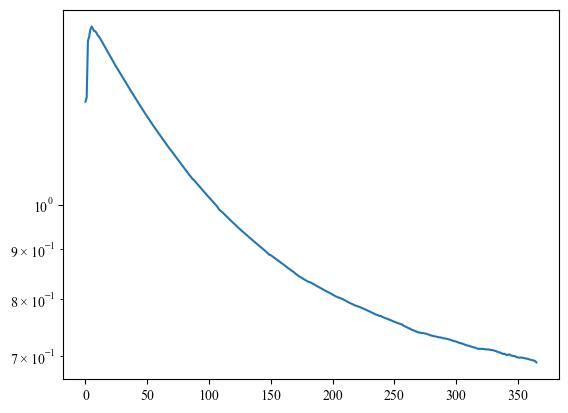

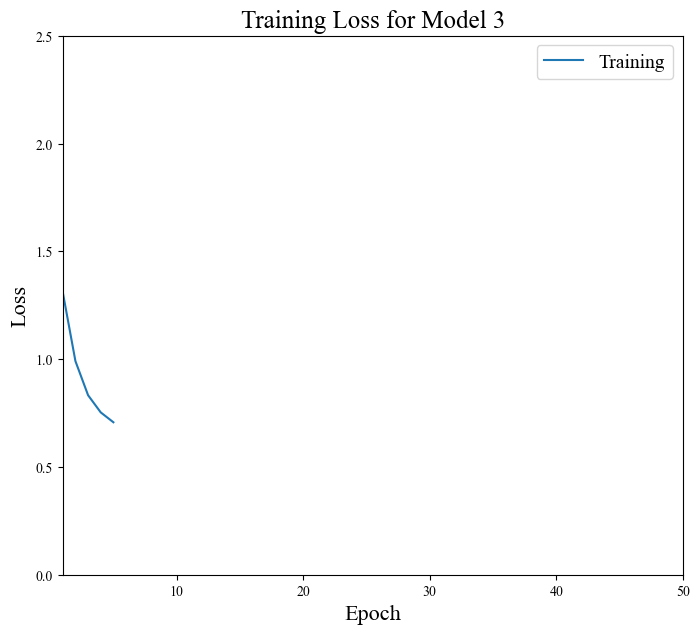

In [19]:
model_3, row_means_3, completed_epochs = experiment_base_CNN(3, loader_ISIC_ArGI, params_CNN, loader_val_ISIC_ArGI)
graph_loss(3, row_means_3, completed_epochs)
model_3.save(f"{CWD}/models/{current_time.tm_year}-{current_time.tm_mon}-{current_time.tm_mday}_model_{3}.keras")
tf.keras.backend.clear_session()

Starting epoch 50/50
Recomputing the sampling probabilities


  0%|          | 0/74 [00:00<?, ?it/s]

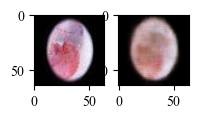

100%|██████████| 74/74 [00:06<00:00, 11.07it/s]
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/88mangos/2024-5-30-model-5/1cfd7afa319b4921b416fd602da2d62b
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [3700] : (0.05861736088991165, 3.692317485809326)
COMET INFO:   Parameters:
COMET INFO:     Adam_amsgrad                 : False
COMET INFO:     Adam_beta_1                  : 0.9
COMET INFO:     Adam_beta_2                  : 0.999
COMET INFO:     Adam_clipnorm                : None
COMET INFO:     Adam_clipvalue               : None
COMET INFO:     Adam_ema_momentum            : 0.99
COMET INFO:     Adam_ema_overwrite_frequency : None
COMET INFO:     Adam_eps

3700
1.4491307869198358
1.0682021812208424
0.8385666774681256
0.7207957258812752
0.6862656177379247
0.6579744157646393
0.6214393717581745
0.579780620704875
0.5504870110495254
0.5367918195158248
0.5497281860193126
0.5654720906463521
0.5183994611746072
0.47307312224490256
0.43667179633059544
0.41756772980055407
0.41418775647640926
0.4047457893725606
0.3920577909712929
0.36537513877915984
0.3317020505024848
0.3109980577022266
0.2931906051698298
0.27224486156065336
0.2508777313734178
0.2355870785663233
0.23016679523875117
0.23129059185802228
0.21720903660224622
0.199605802107729
0.1944648501169534
0.18566972795719666
0.1799031801278109
0.1846035563799476
0.18477494668874941
0.16631479257489484
0.16463348711218476
0.1562424188222039
0.14274177792645645
0.13386148920046043
0.13094896498326322
0.1344497149466755
0.11875411869272488
0.12090929590619241
0.13076946438952455
0.1240494242210273
0.115233486646575
0.1199662042895175
0.1318537974638428
0.12661857716965866


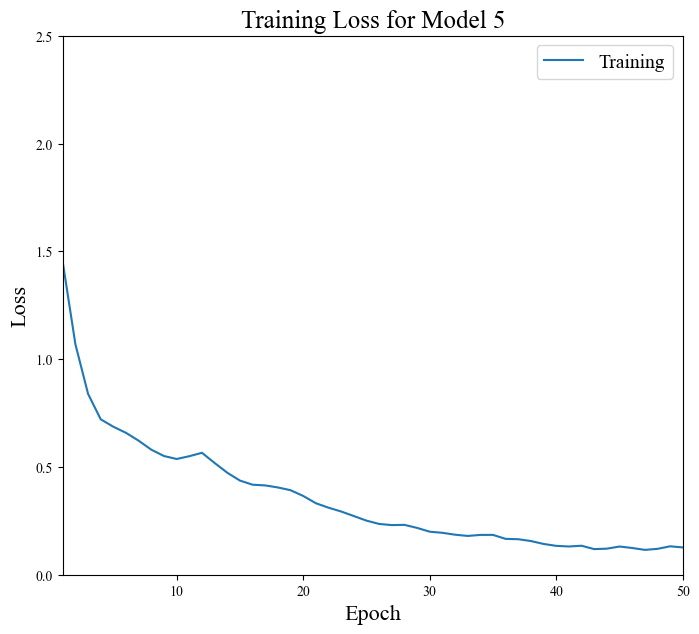

In [20]:
model_5, row_means_5 = experiment_DB_VAE(5, loader_ISIC_DiDI, params_DB_VAE)
graph_loss(5, row_means_5, params_DB_VAE["num_epochs"])
model_5.save(f"{CWD}/models/{current_time.tm_year}-{current_time.tm_mon}-{current_time.tm_mday}_model_{5}.keras")
tf.keras.backend.clear_session()

Starting epoch 50/50
Recomputing the sampling probabilities


  0%|          | 0/74 [00:00<?, ?it/s]

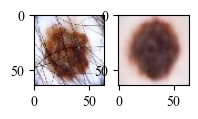

100%|██████████| 74/74 [00:06<00:00, 11.16it/s]
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/88mangos/2024-5-30-model-6/77bd4d9dc25e4649b082c5e7ea3d4389
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [3700] : (0.04711976274847984, 5.520871162414551)
COMET INFO:   Parameters:
COMET INFO:     Adam_amsgrad                 : False
COMET INFO:     Adam_beta_1                  : 0.9
COMET INFO:     Adam_beta_2                  : 0.999
COMET INFO:     Adam_clipnorm                : None
COMET INFO:     Adam_clipvalue               : None
COMET INFO:     Adam_ema_momentum            : 0.99
COMET INFO:     Adam_ema_overwrite_frequency : None
COMET INFO:     Adam_eps

3700
1.1185997757506145
0.9637250805295426
0.8598094765594111
0.754743483327417
0.6654301308049757
0.6272043163965958
0.6244610730932474
0.6193117271808316
0.5834811536072468
0.5717514666841493
0.5628928875321181
0.5441619623121337
0.5139703251062319
0.5144478265250958
0.5050065664853693
0.46855527210156706
0.4467316917765858
0.4308236782170302
0.43843627375651284
0.4351146101253727
0.41298540738269196
0.39897523949277836
0.3557179508089891
0.3197932370405814
0.289634930368759
0.26728634476893715
0.24953448798912137
0.2361211480129472
0.21973491634186076
0.20703171250049124
0.20624860556715416
0.18659201284390345
0.17701830759304343
0.17086142507012042
0.15712678365245947
0.14924768898152713
0.1460211082093246
0.13718402599711801
0.1298244570283338
0.12549568030159547
0.12638192320260394
0.12119792481730217
0.12065976001610988
0.11925501969043469
0.12099796913685675
0.11727029633475625
0.10008867854629985
0.0941379254555015
0.10075372327072932
0.1033969607308712


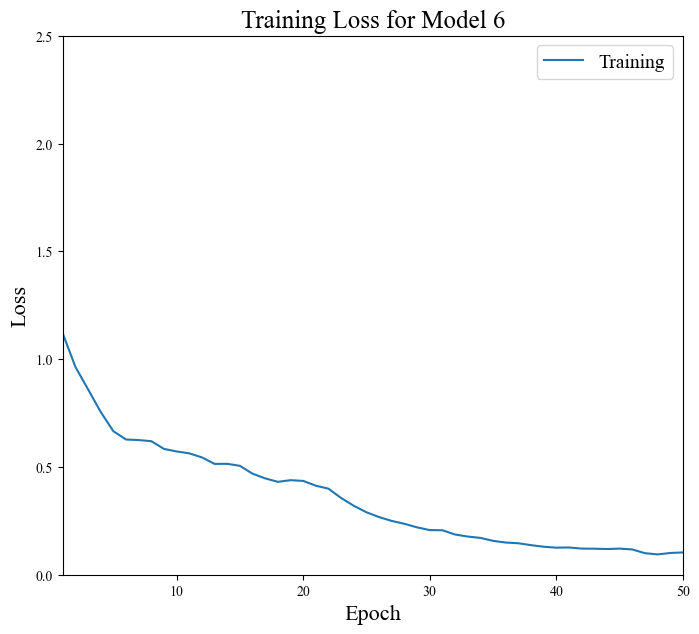

In [21]:
model_6, row_means_6 = experiment_DB_VAE(6, loader_ISIC_ArGI, params_DB_VAE)
graph_loss(6, row_means_6, params_DB_VAE["num_epochs"])
model_6.save(f"{CWD}/models/{current_time.tm_year}-{current_time.tm_mon}-{current_time.tm_mday}_model_{6}.keras")
tf.keras.backend.clear_session()

In [ ]:
for i in range(1,7):
    break ### COMMENT THIS OUT
    if (i % 3 == 1):
        loader = loader_ISIC
        validation_loader = loader_val_ISIC
    elif (i % 3 == 2):
        loader = loader_ISIC_DiDI
        validation_loader = loader_val_ISIC_DiDI
    elif (i % 3 == 0):
        loader = loader_ISIC_ArGI
        validation_loader = loader_val_ISIC_ArGI
    
    if (i <= 3):
        model, row_means, completed_epochs = experiment_base_CNN(i, loader, params_CNN, validation_loader) # with early stopping
        graph_loss(i, row_means, completed_epochs)
        #model, row_means = experiment_base_CNN(i, loader, params_CNN)
        #graph_loss(i, row_means, params_CNN["num_epochs"])
    elif (i <= 6):
        model, row_means = experiment_DB_VAE(i, loader, params_DB_VAE)
        graph_loss(i, row_means, params_DB_VAE["num_epochs"])
    
    model.save(f"{CWD}/models/{current_time.tm_year}-{current_time.tm_mon}-{current_time.tm_mday}_model_{i}.keras")
    tf.keras.backend.clear_session()
    

Starting epoch 1/50
Recomputing the sampling probabilities


  0%|          | 0/74 [00:34<?, ?it/s]


KeyboardInterrupt: 

## Research Ethics
This code makes use of the mitdeeplearning package (Amini, 2024) for the data loading function. 
The DB-VAE for Models 4-6 is inspired by the Debiasing Computer Vision Lab notebook from 6.S191.

### Copyright 2024 MIT 6.S191 Introduction to Deep Learning. All Rights Reserved. 
 
Licensed under the MIT License. You may not use this file except in compliance 
with the License. Use and/or modification of this code outside of 6.S191 must 
reference: 

© MIT 6.S191: Introduction to Deep Learning 
http://introtodeeplearning.com 